In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
from timm.optim import Mars
from types import SimpleNamespace
from IPython.display import HTML
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from decord import VideoReader
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
dataset = datasets.load_dataset("danjacobellis/davis").cast_column('video',datasets.Video()).with_format("torch")

In [4]:
checkpoint = torch.load('checkpoint.pth', map_location="cpu",weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)
model.load_state_dict(state_dict)
model.eval();

In [5]:
overlap = 4
stride = 16
block_size = stride + 2 * overlap
target_w = 1920
target_h = 1080
upsampling_factor = config.F

overlap_pixels = overlap * upsampling_factor  # e.g., 4 * 8 = 32
central_size_pixels = stride * upsampling_factor  # e.g., 16 * 8 = 128

def pad3d(x, p, extra):
    b, c, f, h, w = x.shape
    t = math.ceil(f / p) * p
    fp1 = (t - f) // 2
    fp2 = (t - f) - fp1
    t = math.ceil(h / p) * p
    hp1 = (t - h) // 2
    hp2 = (t - h) - hp1
    t = math.ceil(w / p) * p
    wp1 = (t - w) // 2
    wp2 = (t - w) - wp1
    return torch.nn.functional.pad(x, pad=(
        wp1+extra,
        wp2+extra,
        hp1+extra,
        hp2+extra,
        fp1+extra,
        fp2+extra
    ), mode="reflect")

sample = dataset['train'][0]
video = sample['video']
len_video = len(video)
xr = video.get_batch(range(len_video))
xr = einops.rearrange(xr, 'f h w c -> c f h w')
x = []
for i_frame in range(xr.shape[1]):
    frame = xr[:, i_frame]
    pil_img = to_pil_image(frame)
    resized_img = pil_img.resize((target_w, target_h))
    tensor_frame = pil_to_tensor(resized_img).unsqueeze(1)
    x.append(tensor_frame)
x = torch.cat(x, dim=1).unsqueeze(0)
x = x / 127.5 - 1.0
x = x.to(device)
x_orig = x.clone()
x = pad3d(x, p=config.F * stride, extra=config.F * overlap)

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

In [6]:
# Latent dimensions
T_l, H_l, W_l = latent.shape[2], latent.shape[3], latent.shape[4]
F_padded = T_l * config.F
H_padded = H_l * config.F
W_padded = W_l * config.F

# Initialize output tensor
x_hat = torch.zeros(1, 3, F_padded, H_padded, W_padded, device=device)

# Number of blocks
num_blocks_t = ((T_l - block_size) // stride) + 1
num_blocks_h = ((H_l - block_size) // stride) + 1
num_blocks_w = ((W_l - block_size) // stride) + 1

# Decoding loop
for k_t in range(num_blocks_t):
    for k_h in range(num_blocks_h):
        for k_w in range(num_blocks_w):
            t_start = k_t * stride
            h_start = k_h * stride
            w_start = k_w * stride
            latent_block = latent[:, :, t_start:t_start + block_size,
                                       h_start:h_start + block_size,
                                       w_start:w_start + block_size]
            with torch.no_grad():
                x_hat_block = model.decode(latent_block).clamp(-1, 1)
            # Extract central part
            central_part = x_hat_block[:, :,
                                       overlap_pixels:overlap_pixels + central_size_pixels,
                                       overlap_pixels:overlap_pixels + central_size_pixels,
                                       overlap_pixels:overlap_pixels + central_size_pixels]
            # Placement indices
            t_pixel_start = t_start * upsampling_factor
            h_pixel_start = h_start * upsampling_factor
            w_pixel_start = w_start * upsampling_factor
            x_hat[:, :,
                  t_pixel_start + overlap_pixels:t_pixel_start + overlap_pixels + central_size_pixels,
                  h_pixel_start + overlap_pixels:h_pixel_start + overlap_pixels + central_size_pixels,
                  w_pixel_start + overlap_pixels:w_pixel_start + overlap_pixels + central_size_pixels] = central_part

# Crop to original dimensions
f_start = (F_padded - len_video) // 2
h_start = (H_padded - target_h) // 2
w_start = (W_padded - target_w) // 2
x_hat = x_hat[:, :,
              f_start:f_start + len_video,
              h_start:h_start + target_h,
              w_start:w_start + target_w]

# Final clamping
x_hat = x_hat.clamp(-1, 1)

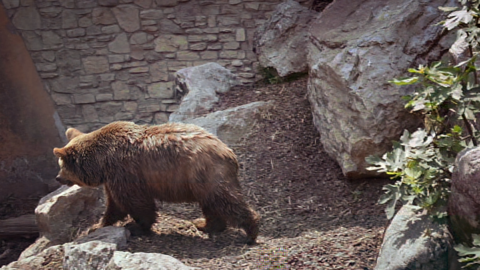

In [8]:
to_pil_image(x_hat[0,:,1]/2+0.5).resize((1920//4,1080//4))

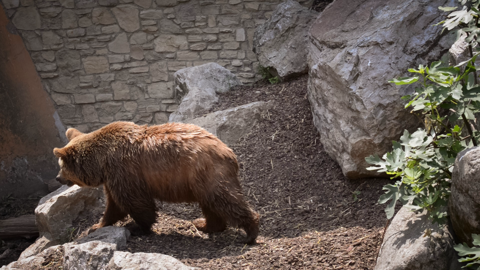

In [9]:
to_pil_image(x_orig[0,:,1]/2+0.5).resize((1920//4,1080//4))

In [10]:
x_orig_01 = x_orig / 2 + 0.5
x_hat_01 = x_hat / 2 + 0.5
PSNR = []
for i_frame in range(x_orig_01.shape[2]):
    mse = torch.nn.functional.mse_loss(x_orig_01[0, :, i_frame], x_hat_01[0, :, i_frame])
    PSNR.append(-10 * mse.log10().item())

In [11]:
np.mean(PSNR)

25.54221601020999